# Installs

In [ ]:
pip install shap

In [ ]:
pip install earthpy

In [ ]:
pip install cartopy

In [ ]:
pip install pyhdf

In [ ]:
pip install polars

# Packages

In [ ]:
import os
import warnings
import datetime
import pytz
import re
import pickle
import functools
from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import numpy as np
import pandas as pd
import numpy.ma as ma
import polars as pl
from shapely.geometry import mapping, box
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

from pyhdf.SD import SD, SDC

import dask.array as da

import pyproj
import re

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import polars as pl
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from tqdm import tqdm
## https://hdfeos.org/software/pyhdf.php
warnings.simplefilter('ignore')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/lpg_analysis')
from model import (
    get_dates_pl,
    process_data,
    get_fourier_components,
    plot_contour,
    get_joint_distribution,
    get_piecewise_contribution,
    y_distribution,
    get_piecewise_posterior,
    run_chain,
    get_post,
)

# Data

## propane

In [ ]:
"""
shape = (n_blocks_per_row, n_blocks_per_row, n_timeperiods, n_vars, n_changepoints) # after axis swap
shape = (120, 120, 560, 6)
axis 3 metric order ['qa', 'std', 'mean', 'percentile_10', 'median', 'percentile_90']
# ndvi valid range -2000 to 10000, fill value = -3000
"""
cities = pd.read_csv("/content/drive/MyDrive/propane/cities.csv").values

# data is monthly
propane = (
    pl.from_pandas(pd.read_csv('/content/drive/MyDrive/propane/demand_residential_monthly.csv'))
    .with_columns(
        period_start = pl.col('period_start').str.to_date(format='%m/%d/%Y'),
        period_ahead_2 = pl.col('period_ahead_2').str.to_date(format='%m/%d/%Y'),
        period_ahead_4 = pl.col('period_ahead_4').str.to_date(format='%m/%d/%Y'),
    )
    # .filter(~pl.col('period_ahead_4').is_null())
)
print(f"propane.shape: {propane.shape}")

dates = propane['period_start'].to_numpy()

propane.head(5)

propane.shape: (114, 6)


year,month,period_start,period_ahead_2,period_ahead_4,demand
i64,i64,date,date,date,f64
2015,1,2015-01-01,2015-03-01,2015-05-01,23.84107
2015,2,2015-02-01,2015-04-01,2015-06-01,23.62496
2015,3,2015-03-01,2015-05-01,2015-07-01,24.963921
2015,4,2015-04-01,2015-06-01,2015-08-01,24.422148
2015,5,2015-05-01,2015-07-01,2015-09-01,26.013106


In [ ]:
price = pd.read_csv("/content/drive/MyDrive/propane/price.csv")
price['date'] = pd.to_datetime(price['date'])
price = pl.from_pandas(price)
price = (
    price
    .with_columns(
        year = pd.to_datetime(price['date']).year.values,
        month = pd.to_datetime(price['date']).month.values,
    )
    .with_columns(
        year = pl.col('year').cast(pl.Int64),
        month = pl.col('month').cast(pl.Int64)
    )
    .group_by(['year', 'month'])
    .agg(
        # pl.min('date'),
        pl.mean('price'),
    )
    .join(
        other=propane.select(['year', 'month']),
        on=['year', 'month'],
        how='inner'
    )
    .sort(['year', 'month'])
)
price

year,month,price
i64,i64,f64
2015,1,47.715625
2015,2,57.240132
2015,3,54.451705
2015,4,54.580357
2015,5,45.565625
2015,6,36.497159
2015,7,38.727273
2015,8,37.440476
2015,9,45.270833


# Data Prep

## y: std

In [ ]:
"""
Y: ndvi
X: fourier components, piecewise_vars = trend, clouds, rain, heat, propane
shape = (n_blocks_per_row, n_blocks_per_row, n_timeperiods, n_vars, n_changepoints)
"""
y_data = propane['demand'].to_numpy()[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]

mu = y_data.mean(axis=2, keepdims=True)
sigma = y_data.std(axis=2, keepdims=True)
y_std = (y_data - mu) / sigma

n_blocks_per_row = y_std.shape[0]

print(f"y_std.shape: {y_std.shape}")

y_std.shape: (1, 1, 114, 1, 1)


## X_fourier

In [ ]:
X_fourier = get_fourier_components(
    n_timeperiods=y_std.shape[2],
    n_blocks_per_row=n_blocks_per_row,
    periodicity=12,
    n_components=4,
)
print(f"X_fourier.shape: {X_fourier.shape}")

X_fourier.shape: (1, 1, 114, 1, 8)


## X: trend

In [ ]:
"""
Y: ndvi
X: fourier components, piecewise_vars = trend, clouds, rain, heat, propane
shape = (n_blocks_per_row, n_blocks_per_row, n_timeperiods, n_vars, n_changepoints)
"""
trend_linspace = np.linspace(start=0, stop=1, num=len(dates))[
    np.newaxis, np.newaxis, :, np.newaxis, np.newaxis
]


# X_trend = X_trend * np.ones(shape=(n_blocks_per_row,n_blocks_per_row,1,1,1))
changepoints_trend, I_trend, X_trend = process_data(
    data=trend_linspace,
    n_blocks_per_row=n_blocks_per_row,
    )

a=I_trend[0, 0, :, 0, :].sum(axis=1)
b=np.concatenate([a[1:], np.array([3]),])
mask_changepoint_dates = a-b == -1
changepoints_trend_dates = dates[mask_changepoint_dates]

print(f"changepoints_trend_dates: {changepoints_trend_dates.squeeze()}")

changepoints.shape: (1, 1, 1, 1, 3)
I_data.shape: (1, 1, 114, 1, 3)
X_std.shape: (1, 1, 114, 1, 1)
changepoints: [-0.85846172  0.          0.85846172]
changepoints_trend_dates: ['2017-05-01' '2019-09-01' '2022-01-01']


## X: propane

### get_propane

In [ ]:
def get_propane_ahead(col):
    propane_ahead = (
        propane
        .join(
            other=dates_pl.select(['year_month']),
            left_on=[col],
            right_on=['year_month'],
            how='inner',
        )
        ['demand']
        .to_numpy()[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]
    )
    return propane_ahead

In [ ]:
"""
Y: ndvi
X: fourier components, piecewise_vars = trend, clouds, rain, heat, propane
shape = (n_blocks_per_row, n_blocks_per_row, n_timeperiods, n_vars, n_changepoints)
"""
changepoints_price, I_price, X_price = process_data(
    data=price['price'].to_numpy()[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis],
    n_blocks_per_row=n_blocks_per_row,
    )

changepoints.shape: (1, 1, 1, 1, 3)
I_data.shape: (1, 1, 114, 1, 3)
X_std.shape: (1, 1, 114, 1, 1)
changepoints: [-0.84627052 -0.18514077  0.63900949]


## X_data

In [ ]:
print(f"X_price.shape: {X_price.shape}")
vars = [
    'trend',
    'price',
    ]
idx_2_var = {i:v for i,v in zip(np.arange(len(vars)), vars)}
var_2_idx = {v:i for v,i in zip(vars, np.arange(len(vars)),)}

X_data = np.concatenate(
    [
        X_trend,
        X_price
    ],
    axis=3,
)
print(f"X_data.shape: {X_data.shape}")

changepoints = np.concatenate(
    [
        changepoints_trend,
        changepoints_price,
    ],
    axis=3,
)
print(f"changepoints.shape: {changepoints.shape}")

I_data = np.concatenate(
    [
        I_trend,
        I_price,
    ],
    axis=3,
)
print(f"I_data.shape: {I_data.shape}")

X_price.shape: (1, 1, 114, 1, 1)
X_data.shape: (1, 1, 114, 2, 1)
changepoints.shape: (1, 1, 1, 2, 3)
I_data.shape: (1, 1, 114, 2, 3)


# EDA

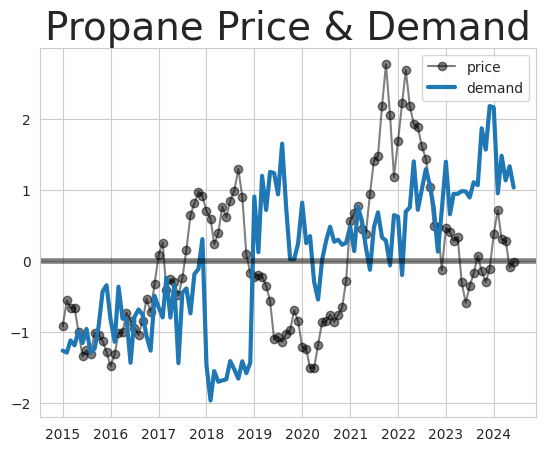

In [ ]:

plt.plot(dates, X_price.squeeze(), label='price', color='k', alpha=0.5, ls='-', marker='o')
plt.plot(dates, y_std.squeeze(), label='demand', lw=3)
plt.axhline(0, ls='-', lw=4, color='k', alpha=0.5)
plt.legend()
plt.title('Propane Price & Demand', fontsize=28);

In [ ]:
print(f"X_fourier.shape: {X_fourier.shape}")
print(f"X_data.shape: {X_data.shape}")
print(f"changepoints.shape: {changepoints.shape}")
print(f"I_data.shape: {I_data.shape}")

X_fourier.shape: (1, 1, 114, 1, 8)
X_data.shape: (1, 1, 114, 2, 1)
changepoints.shape: (1, 1, 1, 2, 3)
I_data.shape: (1, 1, 114, 2, 3)


In [ ]:
jd = get_joint_distribution(
        X_fourier=X_fourier,
        X_data=X_data,
        changepoints=changepoints,
        I_data=I_data,
        n_blocks_per_row=n_blocks_per_row,
        n_vars=X_data.shape[3],
)
jd

<tfp.distributions.JointDistributionNamed 'JointDistributionNamed' batch_shape=[] event_shape={b0: [1, 1, 1, 2, 1], b0_prior: [1, 1, 1, 2, 1], b1: [1, 1, 1, 2, 1], b1_prior: [1, 1, 1, 2, 1], b2: [1, 1, 1, 2, 3], b2_prior: [1, 1, 1, 2, 3], b_fourier: [1, 1, 1, 1, 8], error: [1, 1, 1, 1, 1], fourier_weights_prior: [], y: [1, 1, 114, 1, 1]} dtype={b0: float32, b0_prior: float32, b1: float32, b1_prior: float32, b2: float32, b2_prior: float32, b_fourier: float32, error: float32, fourier_weights_prior: float32, y: float32}>

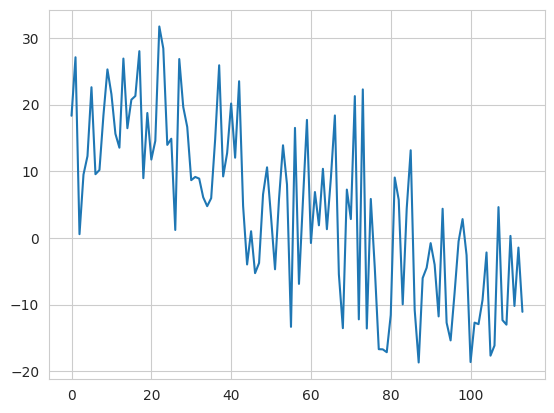

In [ ]:
jd.resolve_graph()
prior_predictive = jd.sample()
prior_predictive.keys()
prior_predictive['y'].shape

plt.plot(prior_predictive['y'][0,0,:,0,0].numpy())

In [ ]:
jd.log_prob(prior_predictive)

<tf.Tensor: shape=(), dtype=float32, numpy=-467.59277>

In [ ]:
params = [p for p in prior_predictive.keys() if 'y' not in p]
print(f"params: {params}")
print(f"len(params): {len(params)}")

params: ['fourier_weights_prior', 'b_fourier', 'b0_prior', 'b0', 'b1_prior', 'b1', 'b2_prior', 'b2', 'error']
len(params): 9


In [ ]:
n_chains = 4
n_samples = 200
sample = jd.sample(n_chains)
sample
del sample['y']
sample.keys()
init_state = [
    tf.zeros_like(samp)
    if ('prior' not in param) & ('error' not in param)
    else tf.ones_like(samp)
    for param, samp in sample.items()
    ]

step_size = [tf.cast(i, dtype=tf.float32) for i in np.ones(len(init_state))]
unconstraining_bijectors = [
    tfb.Identity()
    if ('prior' not in param) & ('error' not in param)
    else tfb.Exp()
    for param in sample.keys()
    ]

jd_pinned = jd.experimental_pin(
    y=y_std
)
target_log_prob_fn = jd_pinned.unnormalized_log_prob

# Train

In [ ]:
start = datetime.datetime.now(pytz.timezone("US/Mountain"))
print(f"start: {start}")

samples, sampler_stat = run_chain(
    init_state=init_state,
    step_size=step_size,
    target_log_prob_fn=target_log_prob_fn,
    unconstraining_bijectors=unconstraining_bijectors,
    num_steps=n_samples,
    burnin=200,
    )

end = datetime.datetime.now(pytz.timezone("US/Mountain"))
print(f"training time: {end - start}")
print(f"len(samples): {len(samples)}")
print(f"samples[1].shape: { samples[1].shape }")

# save
path = '/content/drive/MyDrive/propane/samples_price.pickle'
with open(path, 'wb') as f:
    pickle.dump(samples, f)

# Posterior

In [ ]:
jd = get_joint_distribution(
        X_fourier=X_fourier,
        X_data=X_data,
        changepoints=changepoints,
        I_data=I_data,
        n_blocks_per_row=n_blocks_per_row,
        n_vars=X_data.shape[3],
)

path = '/content/drive/MyDrive/propane/samples_price.pickle'
with open(path, 'rb') as f:
    samples = pickle.load(f)

In [ ]:
dir(jd)
parameter_names = [name for name in jd.parameters['model'].keys() if 'y' not in name]
post = {param: sample for param, sample in zip(parameter_names, samples)}

for i, sample in enumerate(samples):
    print(f"i: {i} {parameter_names[i]} sample.shape: { sample.shape }")

i: 0 fourier_weights_prior sample.shape: (200, 4)
i: 1 b_fourier sample.shape: (200, 4, 1, 1, 1, 1, 8)
i: 2 b0_prior sample.shape: (200, 4, 1, 1, 1, 2, 1)
i: 3 b0 sample.shape: (200, 4, 1, 1, 1, 2, 1)
i: 4 b1_prior sample.shape: (200, 4, 1, 1, 1, 2, 1)
i: 5 b1 sample.shape: (200, 4, 1, 1, 1, 2, 1)
i: 6 b2_prior sample.shape: (200, 4, 1, 1, 1, 2, 3)
i: 7 b2 sample.shape: (200, 4, 1, 1, 1, 2, 3)
i: 8 error sample.shape: (200, 4, 1, 1, 1, 1, 1)


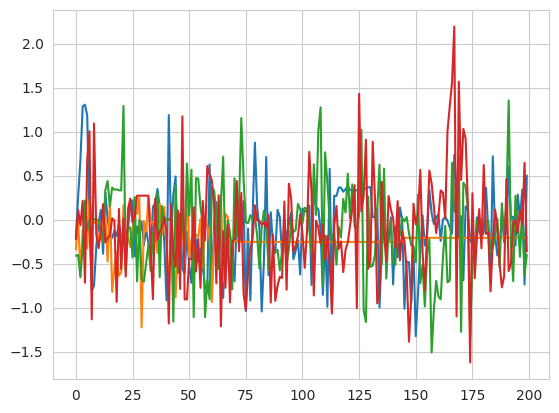

In [ ]:
for chain_idx in range(4):
    plt.plot(samples[7][:, chain_idx, 0, 0, 0, var_2_idx['price'], 0])

In [ ]:
# n_blocks short for n_blocks_per_row
# shape = (n_samples, n_blocks, n_blocks, n_timeperiods, n_vars, n_changepoints)
chunks=[-1, 1, 1, -1, -1, -1]

post = get_post(
    jd=jd,
    samples=samples,
    n_samples=n_samples,
    n_chains=n_chains,
    chunks=chunks,
    )

len(samples): 9
fourier_weights_prior.shape: (800, 1, 1, 1, 1, 1)
b_fourier.shape: (800, 1, 1, 1, 1, 8)
b0_prior.shape: (800, 1, 1, 1, 2, 1)
b0.shape: (800, 1, 1, 1, 2, 1)
b1_prior.shape: (800, 1, 1, 1, 2, 1)
b1.shape: (800, 1, 1, 1, 2, 1)
b2_prior.shape: (800, 1, 1, 1, 2, 3)
b2.shape: (800, 1, 1, 1, 2, 3)
error.shape: (800, 1, 1, 1, 1, 1)


## analysis

In [ ]:
chunks=[-1, 1, 1, -1, -1, -1]
contribution, intercept, slope = get_piecewise_posterior(
    b0=post['b0'],
    b1=post['b1'],
    b2=post['b2'],
    I_data=I_data,
    changepoints=changepoints,
    X_data=X_data,
    chunks=chunks,
)
print(f"post.keys: {post.keys()}")
print(f"contribution.shape: {contribution.shape}")
print(f"slope.shape: {slope.shape}")
print(f"intercept.shape: {intercept.shape}")

post.keys: dict_keys(['fourier_weights_prior', 'b_fourier', 'b0_prior', 'b0', 'b1_prior', 'b1', 'b2_prior', 'b2', 'error'])
contribution.shape: (800, 1, 1, 114, 2, 1)
slope.shape: (800, 1, 1, 114, 2, 1)
intercept.shape: (800, 1, 1, 114, 2, 1)


In [ ]:
c = contribution[:, 0, 0, :, var_2_idx['price'],0].compute()
contribution_upper = np.percentile(a=c, q=90, axis=0)
contribution_lower = np.percentile(a=c, q=10, axis=0)
contribution_upper.shape

(114,)

In [ ]:
post_mean = {
    param: sample.mean(axis=0)
    for param, sample in post.items()
    }
contribution_mean, intercept_mean, slope_mean = get_piecewise_posterior(
    b0=post_mean['b0'],
    b1=post_mean['b1'],
    b2=post_mean['b2'],
    I_data=I_data,
    changepoints=changepoints,
    X_data=X_data,
    chunks=chunks,
)

seasonal_mean = (post_mean['b_fourier'] * X_fourier.numpy()).sum(axis=4, keepdims=True).compute()

print(f"var_2_idx: {var_2_idx}")
print(f"contribution_mean.shape: {contribution_mean.shape}")
print(f"slope_mean.shape: {slope_mean.shape}")
print(f"intercept_mean.shape: {intercept_mean.shape}")
print(f"seasonal_mean.shape: {seasonal_mean.shape}")

var_2_idx: {'trend': 0, 'price': 1}
contribution_mean.shape: (1, 1, 1, 114, 2, 1)
slope_mean.shape: (1, 1, 1, 114, 2, 1)
intercept_mean.shape: (1, 1, 1, 114, 2, 1)
seasonal_mean.shape: (1, 1, 114, 1, 1)


## curves

i: 0, j: 0


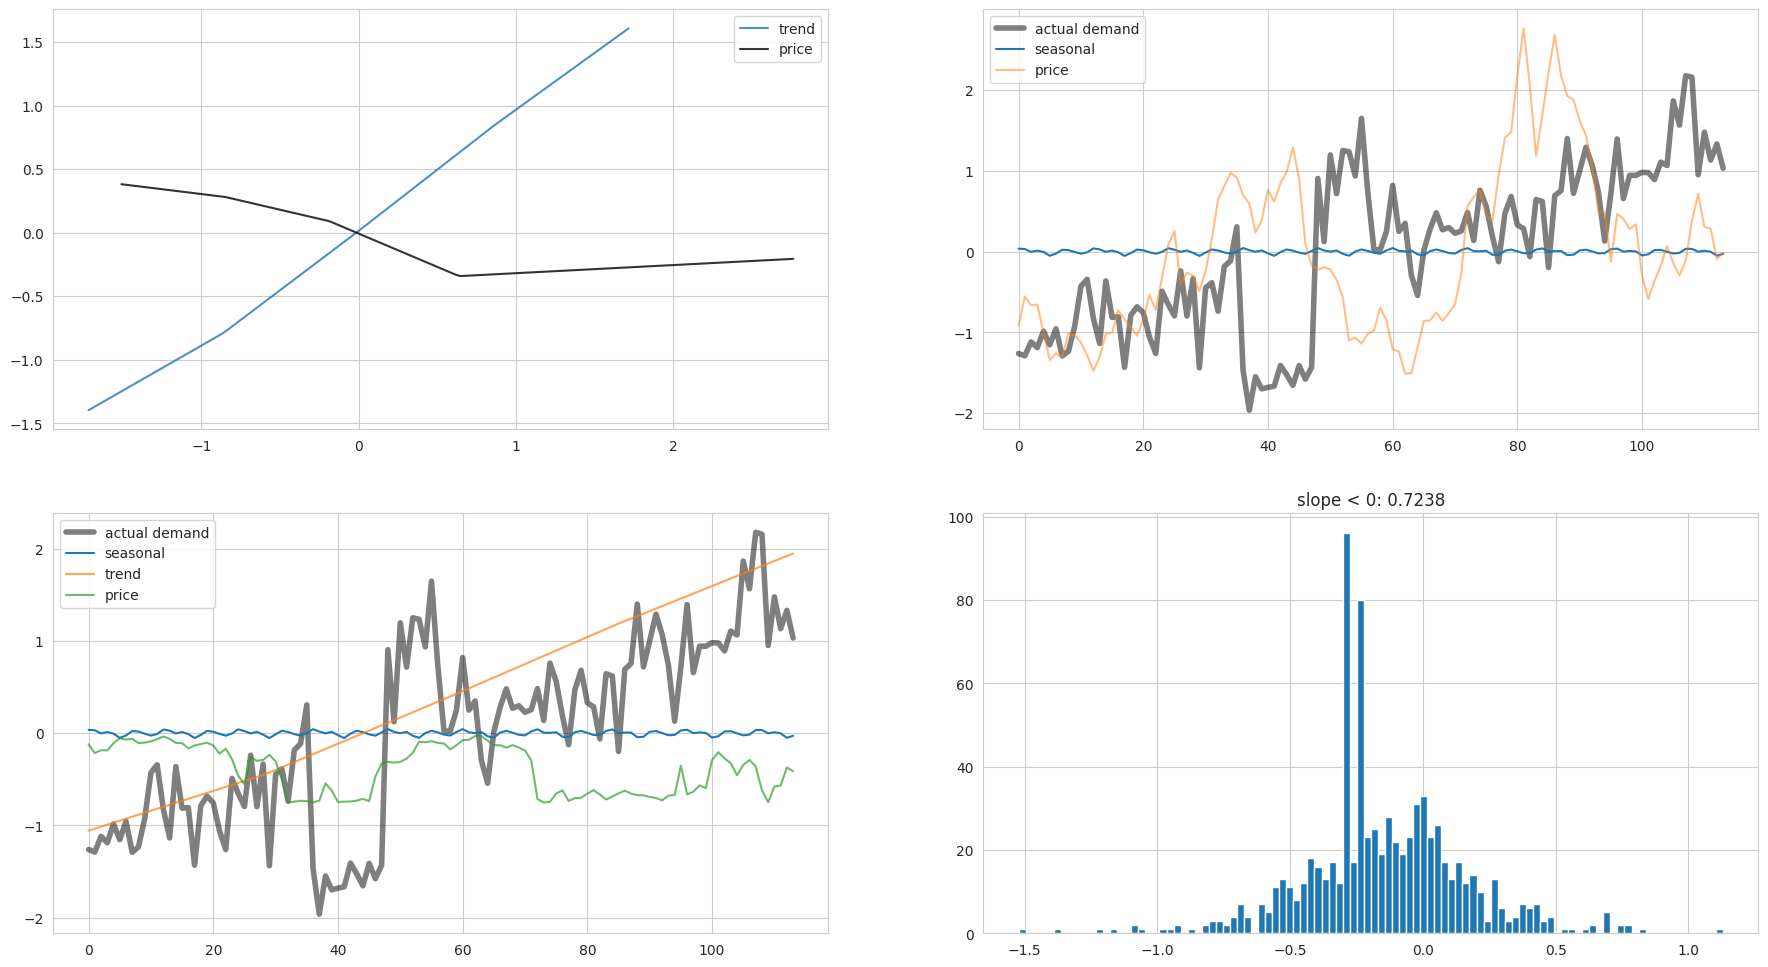

In [ ]:
i,j=np.random.choice(np.arange(10), size=1)[0],np.random.choice(np.arange(10), size=1)[0]
i,j=0,0
print(f"i: {i}, j: {j}")

# X: fourier components, piecewise_vars = trend, clouds, rain, heat, propane
f, ax = plt.subplots(2, 2, figsize=[22,12])
for var_idx in range(len(vars)):
    # if idx_2_var[var_idx] != 'clouds':
        df = (
            pd.DataFrame({
            'data':X_data[i,j,:,var_idx,0],
            'contribution':contribution_mean[0, i,j,:,var_idx,0],
            'upper':contribution_upper,
            'lower':contribution_lower,
            })
            .sort_values(['data'])
            .reset_index()
        )

        # set the x_intercept to zero
        idx = np.argmin(np.abs(df['data'].values))
        x_intercept = df.loc[idx, 'contribution']
        df['contribution'] = df['contribution'] - x_intercept

        if idx_2_var[var_idx]=='price':
            ax[0,0].plot(df['data'], df['contribution'], ls='-', alpha=0.8, label=idx_2_var[var_idx], color='k')
        else:
            ax[0,0].plot(df['data'], df['contribution'], ls='-', alpha=0.8, label=idx_2_var[var_idx])

ax[0,0].legend()

ax[0,1].plot(y_std[i,j,:,0,0], alpha=0.5, lw=4, color='k', label='actual demand')
ax[0,1].plot(seasonal_mean[i,j,:,0,0], label='seasonal')

var = 'price'
ax[0,1].plot(X_data[i,j,:,var_2_idx[var],0], alpha=0.5, label=var)
ax[0,1].legend();

ax[1,0].plot(y_std[i,j,:,0,0], alpha=0.5, lw=4, color='k', label='actual demand')
ax[1,0].plot(seasonal_mean[i,j,:,0,0], label='seasonal')
ax[1,0].plot(contribution_mean[0, i,j,:,var_2_idx['trend'],0], alpha=0.7, label='trend')
ax[1,0].plot(contribution_mean[0, i,j,:,var_2_idx['price'],0], alpha=0.7, label='price')

ax[1,0].legend()

slope_estimates = slope[:, i, j, 0, var_2_idx['price'], :].compute().flatten()
ax[1,1].set_title(f"slope < 0: {(slope_estimates<0).mean():.4f}")
ax[1,1].hist(slope_estimates, bins=100);

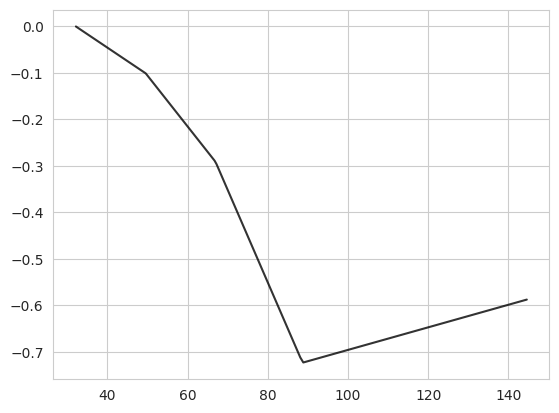

In [ ]:
df = (
    pd.DataFrame({
    'data':price['price'],
    'contribution':contribution_mean[0, i,j,:,var_idx,0],
    })
    .sort_values(['data'])
    .reset_index()
)

# set the x_intercept to zero
idx = np.argmin(np.abs(df['data'].values))
x_intercept = df.loc[idx, 'contribution']
df['contribution'] = df['contribution'] - x_intercept

plt.plot(df['data'], df['contribution'], ls='-', alpha=0.8, label=idx_2_var[var_idx], color='k')

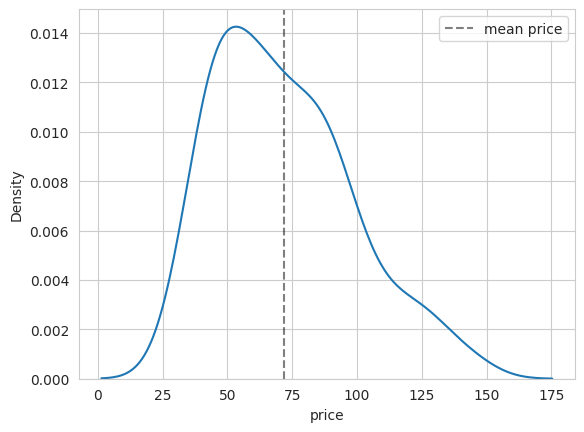

In [ ]:
sns.kdeplot(data=price, x='price')
plt.axvline(np.mean(price['price'].to_numpy()), color='k', ls='--', alpha=0.5, label='mean price')
plt.legend()

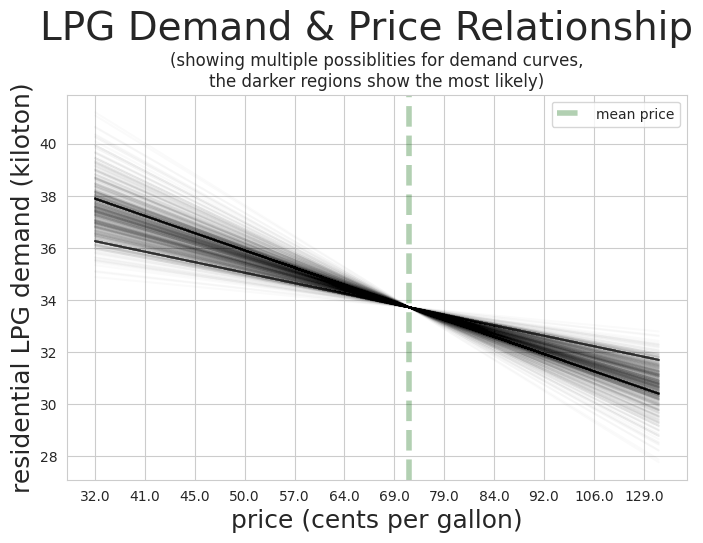

In [ ]:
f, ax = plt.subplots(1, 1, figsize=[8,5])
for s in range(contribution.shape[0]):
# for s in range(2):
    df = (
        pd.DataFrame({
        'data':X_data[i,j,:,var_2_idx['price'],0],
        'contribution':contribution[s,i,j,:,var_2_idx['price'],0],
        })
        .sort_values(['data'])
        .reset_index()
    )
    df['contribution'] = np.linspace(
        start=np.max(df['contribution']),
        stop=np.min(df['contribution']),
        num=len(df['contribution']),
        )
    # set the x_intercept to zero
    idx = np.argmin(np.abs(df['data'].values.round(5)))
    x_intercept = df.loc[idx, 'contribution']
    df['contribution'] = df['contribution'] - x_intercept
    x = np.arange(len(df['contribution']))
    p = price['price'].sort().to_numpy()
    price_mean_idx = np.argmin(np.abs(p - p.mean()))

    plt.plot(x, df['contribution']*sigma.squeeze() + mu.squeeze(), ls='-', alpha=0.02, color='k')
plt.suptitle('LPG Demand & Price Relationship', y=1.05, fontsize=28)
plt.title('(showing multiple possiblities for demand curves,\nthe darker regions show the most likely)')
plt.xlabel('price (cents per gallon)', fontsize=18)
plt.xticks(ticks=x[::10], labels=p[::10].round())
plt.ylabel('residential LPG demand (kiloton)', fontsize=18)
plt.axvline(x[price_mean_idx], ls='--', lw=4, color='darkgreen', alpha=0.3, label='mean price')
plt.legend();

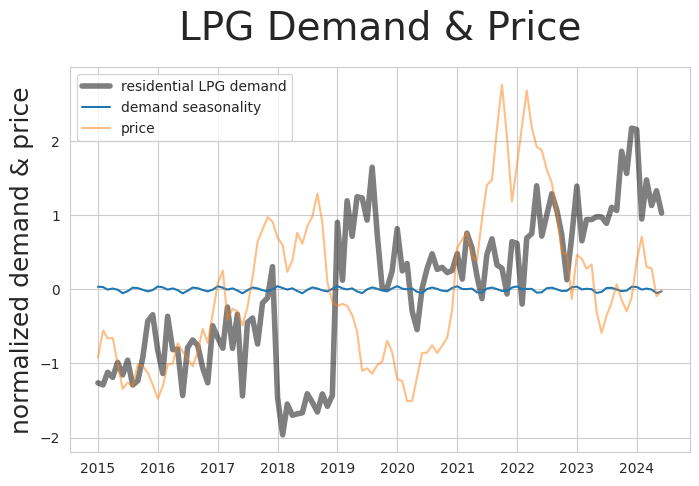

In [ ]:
plt.figure(figsize=[8,5])

plt.plot(dates, y_std[i,j,:,0,0], alpha=0.5, lw=4, color='k', label='residential LPG demand')
plt.plot(dates, seasonal_mean[i,j,:,0,0], label='demand seasonality')
var = 'price'
plt.plot(dates, X_data[i,j,:,var_2_idx[var],0], alpha=0.5, label=var)

plt.title('LPG Demand & Price', y=1.05, fontsize=28)
plt.ylabel('normalized demand & price', fontsize=18)
plt.legend();